In [17]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *


from sklearn.naive_bayes import GaussianNB # Decision Tree
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

%precision %.7g

'%.7g'

# 1. Explore

# 2. Build and Evaluate Model

In [7]:
spam = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/spam.csv")
spam.head()

,is_spam,viagra,love,dollar,buy
0,1,0,0,0,0
1,1,0,0,1,1
2,0,0,0,0,0
3,1,1,0,1,1
4,1,1,0,0,0


[0.9, 0.94, 0.9, 0.9]
0.9099999999999999


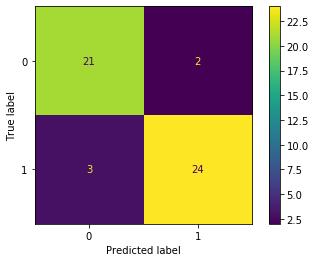

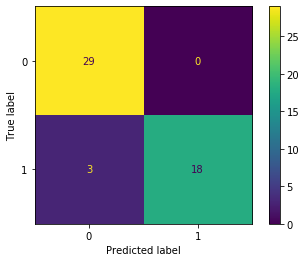

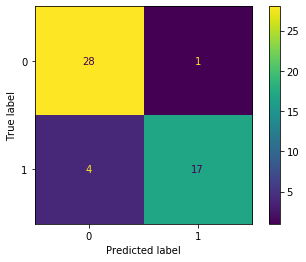

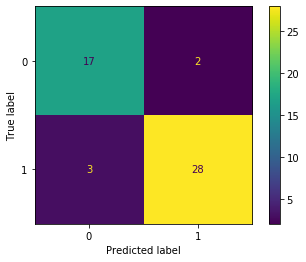

In [8]:
X = spam[["viagra", "love", "dollar","buy"]]
y = spam["is_spam"]


kf = KFold(n_splits = 4)
nb = GaussianNB()
acc = []
for train, test in kf.split(X,y):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y[train]
    y_test = y[test]
    
    
    
    nb.fit(X_train,y_train)
    acc.append(nb.score(X_test,y_test))
    plot_confusion_matrix(nb, X_test,y_test)
    
print(acc)
print(np.mean(acc))

In [13]:
# Let's check by hand

# Hello,
# I hope you are well. Honestly I am doing super well! I have the urge to buy something crazy. Maybe one of those giant
# bean bags from the mall. A love sac. Well. Another day, another dollar. 
# Sincerely,
# Dad


nb.predict(np.array([0,1,1,1]).reshape(1,-1))

array([1])

In [15]:
spam.groupby("is_spam").mean()

,viagra,love,dollar,buy
is_spam,,,,
0,0.03,0.36,0.02,0.02
1,0.32,0.05,0.83,0.74


In [20]:
spam_score = 0.5 * (1-0.32) * 0.05 * 0.83 * 0.74
ham_score = 0.5 * (1-0.03) * 0.36 * 0.02 * 0.02

print("Spam", f"{spam_score:.9f}")
print("Ham", f"{ham_score:.9f}")

Spam 0.010441400
Ham 0.000069840
